# Generate network of genes and proteins up/down regulated by NANOG induction

Based on data from Tiana et al. Science Advances, 2022, in which the authors "aimed to understand the role of Oct4 and Nanog beyond pluripotency. We have characterized the transcriptional changes caused by gain of function of these factors and determined that they regulate many developmental regulators in a dual fashion, repressing their expression at E7.5 and activating them at E9.5"

Here, I combined their list of up/down regulated genes with protein-protein interaction and transcription factor databases to generate a network that describes connections between the different genes and their respective proteins.

In [1]:
import json
import pickle
import networkx as nx

In [2]:
from matplotlib import pyplot as plt

## Match genes in Tiana et al data to their respective proteins

In [3]:
gene_protein = pickle.load(open('../data/gene_protein_ids.pickle','rb'))

In [4]:
data_genes = []
datafile = open('../data/tiana_etal_science_advances_2022.csv')
header = next(datafile)
for line in datafile:
    s=line.strip().split(',')
    data_genes.append(s[0])

gene_graph = nx.DiGraph()

protein_gene_matches = 0
for gene in data_genes:
    if gene in gene_protein:
        protein_gene_matches += 1 
        protein = gene_protein[gene]
        gene_graph.add_edge(('gene', gene), ('protein', protein), type='gene_protein')

print('num genes in data               ', len(data_genes))
print('num proteins matched to genes   ', protein_gene_matches)

num genes in data                1638
num proteins matched to genes    1489


## Protein protein interaction data (STRINGdb)

In [5]:
# Extract and transform relevant data from STRING database dump file
def process_line(line):
    s = line.strip().split(' ')
    # Remove the 10090 prefix that indicates this is from the mouse species data in STRING
    s[0] = s[0].split('.')[1]
    s[1] = s[1].split('.')[1]
    for i,c in enumerate(s[2:]):
        s[i+2] = int(c)
        
    return s

In [6]:
columns = ['protein1',
'protein2',
'neighborhood',
'fusion',
'cooccurence',
'coexpression',
'experimental',
'database',
'textmining',
'combined_score']

In [7]:
for c in list(enumerate(columns)): print(c)

(0, 'protein1')
(1, 'protein2')
(2, 'neighborhood')
(3, 'fusion')
(4, 'cooccurence')
(5, 'coexpression')
(6, 'experimental')
(7, 'database')
(8, 'textmining')
(9, 'combined_score')


In [10]:
# Use linux utility wc to quickly count the number of lines in the string data file
n = !wc -l ../data/string_db_mouse_ppi.txt
n = int(n[0].split(' ')[0])

step = int(n/20)

In [11]:
# Create a networkx graph from the string data
string_file = open('../data/string_db_mouse_ppi.txt')

header = next(string_file)

string_graph = nx.Graph()
for i,line in enumerate(string_file):
    line = process_line(line)
    src = line[0]
    tgt = line[1]
    coexpression = line[5]
    experimental = line[6]
    
    string_graph.add_edge(('protein', src), ('protein', tgt), 
                          coexpression=coexpression, experimental=experimental)
    # Print progress
    if i%step==0:
        print(int(i/n*100))

0
4
9
14
19
24
29
34
39
44
49
54
59
64
69
74
79
84
89
94
99


In [12]:
len(string_graph)

21317

In [13]:
pickle.dump(string_graph, open('../data/string_graph.pickle','wb'))

## Remove low quality edges from graph

In [14]:
filtered_graph = nx.Graph()
for edge in string_graph.edges(data=True):
    attrs = edge[2]
    if attrs['coexpression'] > 250:
        filtered_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
                                type='coexpression', weight=attrs['coexpression'])
    if attrs['experimental'] > 250:
        filtered_graph.add_edge(u_of_edge=edge[0], v_of_edge=edge[1], 
                                type='experimental', weight=attrs['experimental'])

In [15]:
filtered_graph.number_of_edges()

412836

In [16]:
filtered_graph.number_of_nodes()

16211

## Load Transcription factors (TRRUST)

In [17]:
# These data files provide mappings between gene/protein names (TP53, NANOG, etc) to their Ensembl ID
protein_names = pickle.load(open('../data/protein_names.pickle','rb'))
gene_names = pickle.load(open('../data/gene_names.pickle','rb'))

In [18]:
tf_graph = nx.DiGraph()
n_tfs = 0
for line in open('../data/trrust_rawdata.mouse.tsv'):
    s = line.split('\t')
    src, tgt, etype, dois = s
    src = src.upper()
    tgt = tgt.upper()
    # Each protein and gene name can map to multiple different Ensembl ID's.
    # For example, each a protein can be translated from multiple different splice variants, each of which has a 
    # unique Ensembl ID
    # Below, we create connections between all ensembl id's associated with each source/target name
    if src in protein_names and tgt in protein_names:
        src_ids = protein_names[src]
        tgt_ids = gene_names[tgt]
        for src_id in src_ids:
            for tgt_id in tgt_ids:
                tf_graph.add_edge(('protein',src_id), ('gene',tgt_id), type='tf', effect=etype, dois=dois.strip())
    n_tfs+=1

In [19]:
tf_graph.number_of_nodes()

5523

In [20]:
tf_graph.number_of_edges()

31682

In [21]:
n_tfs

7057

## Combine protein-protein, transcription factors, and gene-protein interactions

In [22]:
data_proteins = [node for node in gene_graph.nodes() if node[0]=='protein']

In [23]:
data_genes = [node for node in gene_graph.nodes() if node[0]=='gene']

In [24]:
len(data_proteins)

1489

In [25]:
len(data_genes)

1489

In [26]:
data_protein_interactions = filtered_graph.subgraph(data_proteins)

In [27]:
combined = nx.compose(gene_graph, data_protein_interactions.to_directed())

In [28]:
combined.number_of_nodes()

2978

In [29]:
combined.number_of_edges()

3345

In [30]:
data_tfs = tf_graph.subgraph(gene_graph.nodes())

In [31]:
data_tfs.number_of_nodes()

511

In [32]:
data_tfs.number_of_edges()

380

In [33]:
combined = nx.compose(combined, data_tfs)

In [34]:
combined.number_of_nodes()

2978

In [35]:
combined.number_of_edges()

3725

## Filter the combined graph to only the largest connected component

The rationale for this is that most of the disconnected components are extremely small in size (i.e. a single gene-protein pair), meaning that we don't have good prior knowledge for how they are regulated by other genes/proteins in the system.  

Instead we are only interested in the "core" set of interacting genes. These are presumably the set that are most strongly influenced by the induction of NANOG, while the genes/proteins in the disconnected components might be regulated primarily by other systems.

In [36]:
# Size of the connected components of the network
sorted([len(cc) for cc in nx.weakly_connected_components(combined)], reverse=True)[:10]

[990, 10, 8, 6, 6, 4, 4, 4, 4, 4]

In [37]:
# Grab the subgraph corresponding to the largest connected component
connected_graph_nodes = sorted([cc for cc in nx.weakly_connected_components(combined)], key=len, reverse=True)[0]
connected_graph = combined.subgraph(connected_graph_nodes)

In [38]:
# Basic quality checks to ensure that the connected component subgraph is correct
print(nx.is_weakly_connected(connected_graph))
print(nx.number_of_nodes(connected_graph))
print(nx.number_of_edges(connected_graph))

True
990
2680


In [39]:
from collections import Counter
from pprint import pprint

### Statistics of largest connected component

In [40]:
# Edge types in the giant component
edge_types = Counter()
for edge in connected_graph.edges(data=True):
    edge_types[edge[2]['type']] += 1
pprint(edge_types.most_common())

[('experimental', 1186),
 ('coexpression', 624),
 ('gene_protein', 495),
 ('tf', 375)]


In [41]:
# Average degree
nx.number_of_edges(connected_graph)/nx.number_of_nodes(connected_graph)

2.707070707070707

### Degree distribution of largest connected component

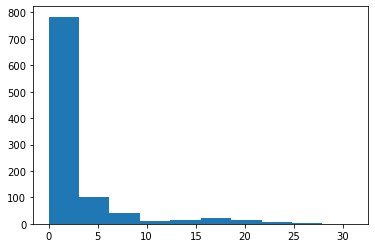

In [42]:
plt.hist(dict(connected_graph.in_degree).values());

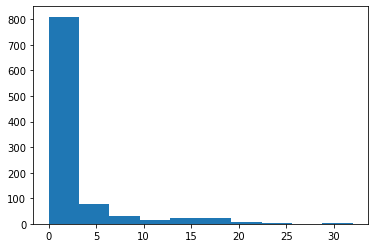

In [43]:
plt.hist(dict(connected_graph.out_degree).values());

## Check that NANOG is in the largest connected component

In [44]:
nanog_ids = gene_names['NANOG']
for nanog_id in nanog_ids:
    nanog_id = ('gene', nanog_id)
    if nanog_id in connected_graph:
        print(nanog_id, connected_graph.in_degree[nanog_id], connected_graph.out_degree[nanog_id])

('gene', 'ENSMUSG00000012396') 10 1


In [45]:
nanog_ids = protein_names['NANOG']
for nanog_id in nanog_ids:
    nanog_id = ('protein', nanog_id)
    if nanog_id in connected_graph:
        print(nanog_id, connected_graph.in_degree[nanog_id], connected_graph.out_degree[nanog_id])

('protein', 'ENSMUSP00000012540') 9 15


## Export connected component in gephi compatible format

In [46]:
nodefile = open('../data/connected_graph_nodes.csv','w')
nodefile.write('Id,data\n')
for node in connected_graph.nodes():
    t,v = node
    nodefile.write(','.join((v,t)) + '\n')
nodefile.close()

In [47]:
set(attrs.keys())

{'coexpression', 'experimental'}

In [48]:
all_attrs = set()
for edge in connected_graph.edges(data=True):
    src, tgt, attrs = edge
    for key in attrs.keys():
        all_attrs.add(key)

In [49]:
all_attrs = list(all_attrs)

In [50]:
edgefile = open('../data/connected_graph_edges.csv','w')
edgefile.write('Source,Target,'+','.join(all_attrs)+'\n')
for edge in connected_graph.edges(data=True):
    (tsrc, src), (ttgt, tgt), attrs = edge
    line = [src, tgt]
    for attr in all_attrs:
        if attr in attrs:
            line.append(attrs[attr])
        else:
            line.append('')

    edgefile.write(','.join([str(_) for _ in line]) + '\n')
edgefile.close()